- The final project of supervised machine learning
- lecturere -- Barnard Bart
- student -- Azadeh Pirzadeh

### Covid-19 retrospective of the lifelines longitudinal study participants 
In this project, I am going to analyze the most important features that can predict the quality of life during Corona pandemic. I tried to check many different factors and find the most correlated ones and then make a model with those to predict the quality of life. I used the dataset of lifeline biobank and extracted the quality of life and then calculate the average the quality of life of participants who filled out the questionnaire per day, because of some limitation rules I can not share the dataset with information from questionnaires, so I made a csv with an average of quality of life base on date and then combine with other datasets and finally, you can use the "wellbeing_data_collection.csv" as the final dataset.\
It appears that this project is a kind of regression supervised machine learning.

In [2]:
#import the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno 
import seaborn as sns
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.preprocessing import StandardScaler , PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import matplotlib.dates as mdates

### dataset
This dataset includes 482 rows and 47 columns that I explained the columns below.
**column name** | **explaination**
-----|-----
date |the specific date that participants fill the questionnaire in lifelines
quality_of_life |the average quality of life of participants who filled out the questionnaire on that specific date
age |the average of participants age who filled out the questionnaire on that specific date
Euro95(€/L),Diesel(€/L),Lpg(€/L), Open,High,Low,Close,adj_close, Volume,rolling_mean_AEX|Finantial feature
news_sentiment |daily news sentiment index(social)
wind_gust,min_temp,avg_temp,max_temp, sunshine_duration,max_potential_sunshine_duration, precipitation_duration,max_precipitation_amount,max_humidity,min_humidity, sunrise,sunset,daylight_hours,14day_rollling_avg_temp | weather feature
stringency index | composite measure based on nine response indicators including school closures, workplaceclosures,and travel bans, rescaled to a value from 0 to 100 (100 = strictest), you can see this website for more information "https://ourworldindata.org/covid-stringency-index#learn-more-about-the-data-source-the-oxford-coronavirus-government-response-tracker"
icu_patients,daily_hospitalization,reproduction_rate,new_cases, new_deaths,total_cases,total_deaths,total_boosters,14day_rollling_hospitalization | hospitalitity features
counts_per_day | number of participants who filled out the questionnaire on that specific date


In [3]:
#read the data
df=pd.read_csv('wellbeing_data_collection.csv')
#drop the Unnamed column
df=df.iloc[:,1:]
#check the size of dataset
print("size of dataset: ",df.shape)
df.head()

size of dataset:  (482, 47)


,date,quality_of_life,age,Euro95(€/L),Diesel(€/L),Lpg(€/L),Open,High,Low,Close,...,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,counts_per_day,sunrise,sunset,daylight_hours,14day_rollling_avg_temp,14day_rollling_hospitalization
0,4/2/2020,8.000000,65.000000,1.486,1.237,0.568,473.980011,482.660004,468.119995,478.279999,...,NaN,NaN,NaN,NaN,1,7.066667,20.166667,13.100000,6.2000,2807.000000
1,4/6/2020,7.297588,54.378883,1.476,1.239,0.560,486.260010,491.679993,482.690002,489.820007,...,NaN,NaN,NaN,NaN,7340,6.900000,20.300000,13.400000,10.6000,2859.500000
2,4/7/2020,7.263230,55.309461,1.475,1.238,0.556,503.970001,508.559998,494.109985,499.850006,...,NaN,NaN,NaN,NaN,9914,6.866667,20.316667,13.450000,10.9500,2810.666667
3,4/8/2020,7.343911,55.432321,1.473,1.237,0.543,496.190002,500.709992,491.489990,500.709992,...,NaN,NaN,NaN,NaN,7543,6.833333,20.350000,13.516667,11.5375,2824.000000
4,4/9/2020,7.304743,55.732974,1.471,1.238,0.547,506.549988,511.929993,499.049988,508.040008,...,NaN,NaN,NaN,NaN,6857,6.783333,20.383333,13.600000,11.2600,2805.800000


In [4]:
#check the type
print(df.dtypes)
#change the type of date from object to datetime
df['date']=pd.to_datetime(df['date'])

date                                object
quality_of_life                    float64
age                                float64
Euro95(€/L)                        float64
Diesel(€/L)                        float64
Lpg(€/L)                           float64
Open                               float64
High                               float64
Low                                float64
Close                              float64
adj_close                          float64
Volume                             float64
Consumer_trust                     float64
Economic_climate                   float64
Buy_willingness                    float64
annual_rate_of_change              float64
annual_rate_of_change_derived      float64
rolling_mean_AEX                   float64
news_sentiment                     float64
wind_gust                            int64
min_temp                           float64
avg_temp                           float64
max_temp                           float64
sunshine_du

I plotted the quality of life to have an overview of it.

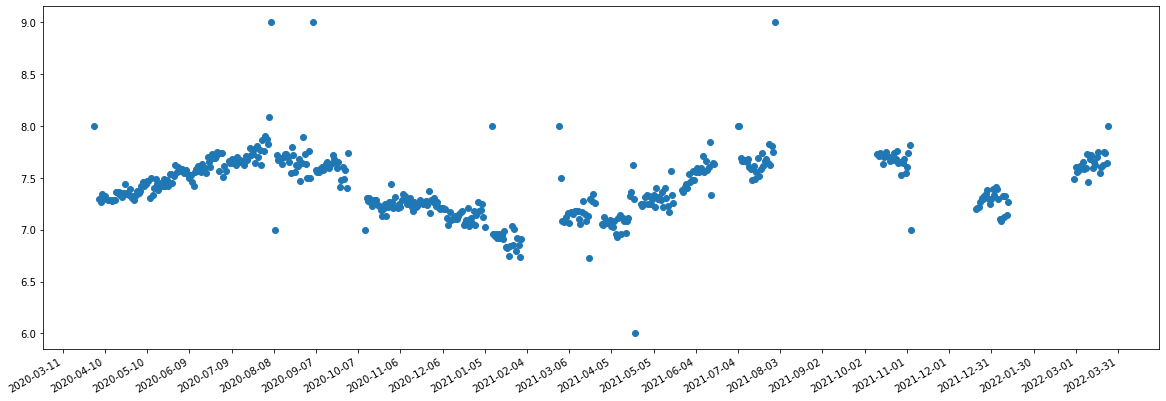

In [5]:
#plot of quality of life
plt.figure(figsize=(20,7))
plt.scatter(df['date'],df['quality_of_life'])
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=30))
plt.gcf().autofmt_xdate()
plt.show()

As you can see there are many outliers so I tried to delete the outlier by checking the number of participants who filled out the questionnaire per day. you can see the result below.

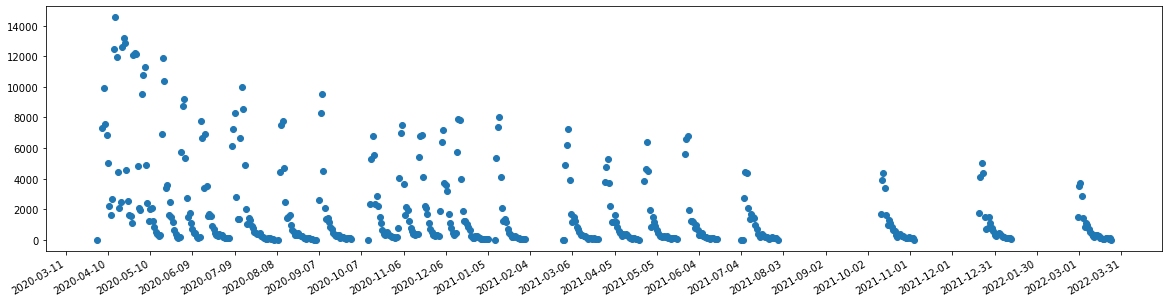

In [6]:
plt.figure(figsize=(20,5))
plt.scatter(df['date'],df['counts_per_day'] )
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=30))
plt.gcf().autofmt_xdate()
plt.show()

As you can see, the number of people who filled out the questionnaire was declined during the time so try to make an outlier to drop the days that are not accurate, on the other hand, I deleted the days which on that specific day, the number of participants who filled out the questionnaire was more than 50 people. The reason I chose 50 is that with just losing 19 rows, I can get a good result as you can see in the plot below but if I choose more than 50 I will lose more rows.

size of dataset after outlier : 463


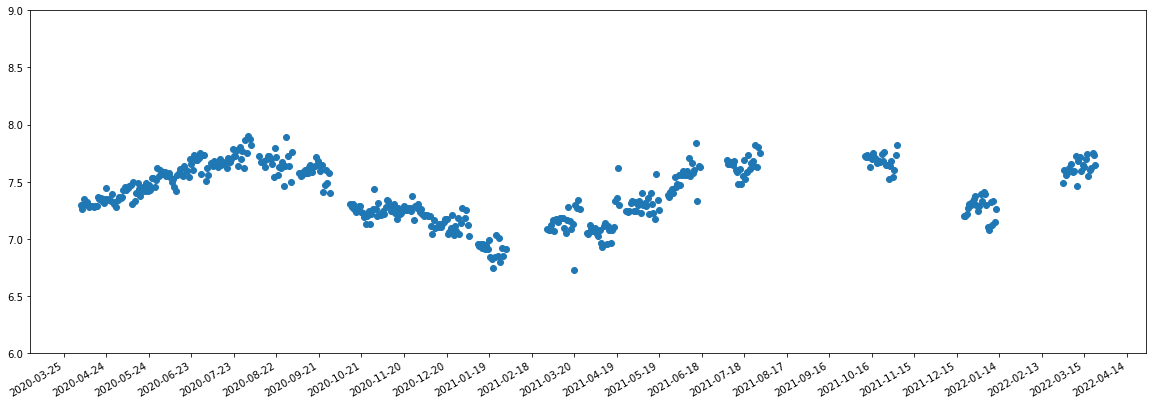

In [7]:
#create outlier
df = df[df['counts_per_day'] > 50]
print("size of dataset after outlier :",len(df))
plt.figure(figsize=(20,7))
plt.scatter(df['date'],df['quality_of_life'])
plt.ylim(6,9)
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=30))
plt.gcf().autofmt_xdate()
plt.show()
#You can see, with this outlier I can delete the unrelated point

In the bellow plot, you can see the null data with white color. Then I tried to count the null data and finally drop the columns that had the most nulls ( 449 null and 437 null out of 463 )and were not useful.

<AxesSubplot:>

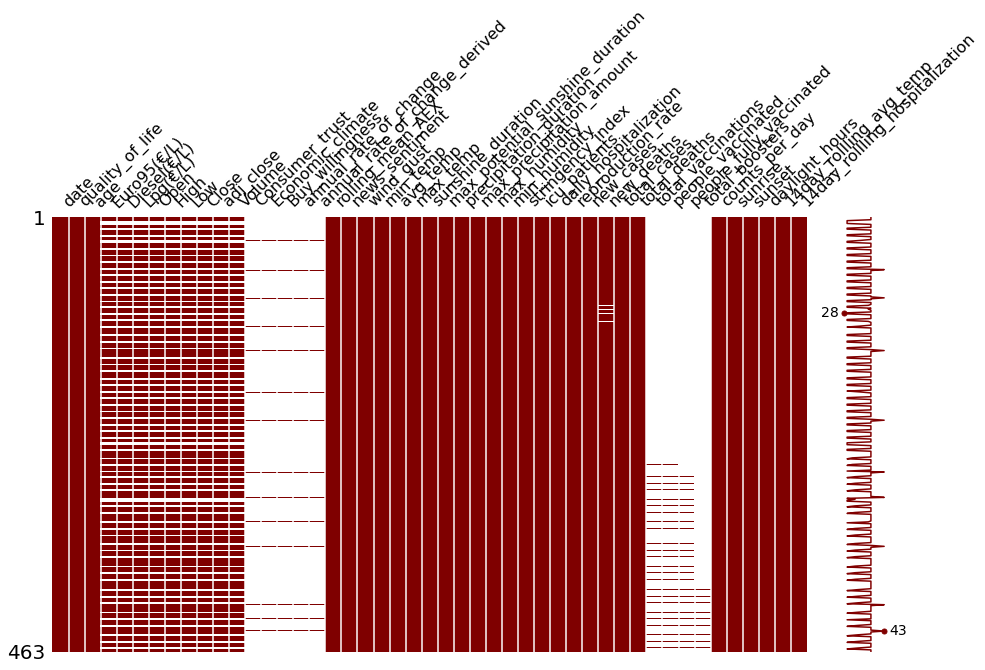

In [8]:
#plot the null data
msno.matrix(df, figsize=(15,8), color=(0.5,0,0))

In [9]:
#check the null data
print(df.isna().sum())
#drop the columns that have very little information and are not useful
df=df.drop(columns=['Consumer_trust', 'Economic_climate','Buy_willingness', 'annual_rate_of_change','annual_rate_of_change_derived',\
    'total_vaccinations', 'people_vaccinated','people_fully_vaccinated'])

date                                 0
quality_of_life                      0
age                                  0
Euro95(€/L)                        129
Diesel(€/L)                        129
Lpg(€/L)                           129
Open                               129
High                               129
Low                                129
Close                              129
adj_close                          129
Volume                             129
Consumer_trust                     449
Economic_climate                   449
Buy_willingness                    449
annual_rate_of_change              449
annual_rate_of_change_derived      449
rolling_mean_AEX                     0
news_sentiment                       0
wind_gust                            0
min_temp                             0
avg_temp                             0
max_temp                             0
sunshine_duration                    0
max_potential_sunshine_duration      0
precipitation_duration   

At this level, I wanted to decide what should I do for the columns that have 129 nulls out of 463 and find a logical answer to this question: Is it better to drop these columns or interpolate the values?\
So I plotted the heat map and see there is a very low correlation(less than 0.2) between these columns and quality of life so I decided to drop those instead of spending time to interpolating.

<AxesSubplot:>

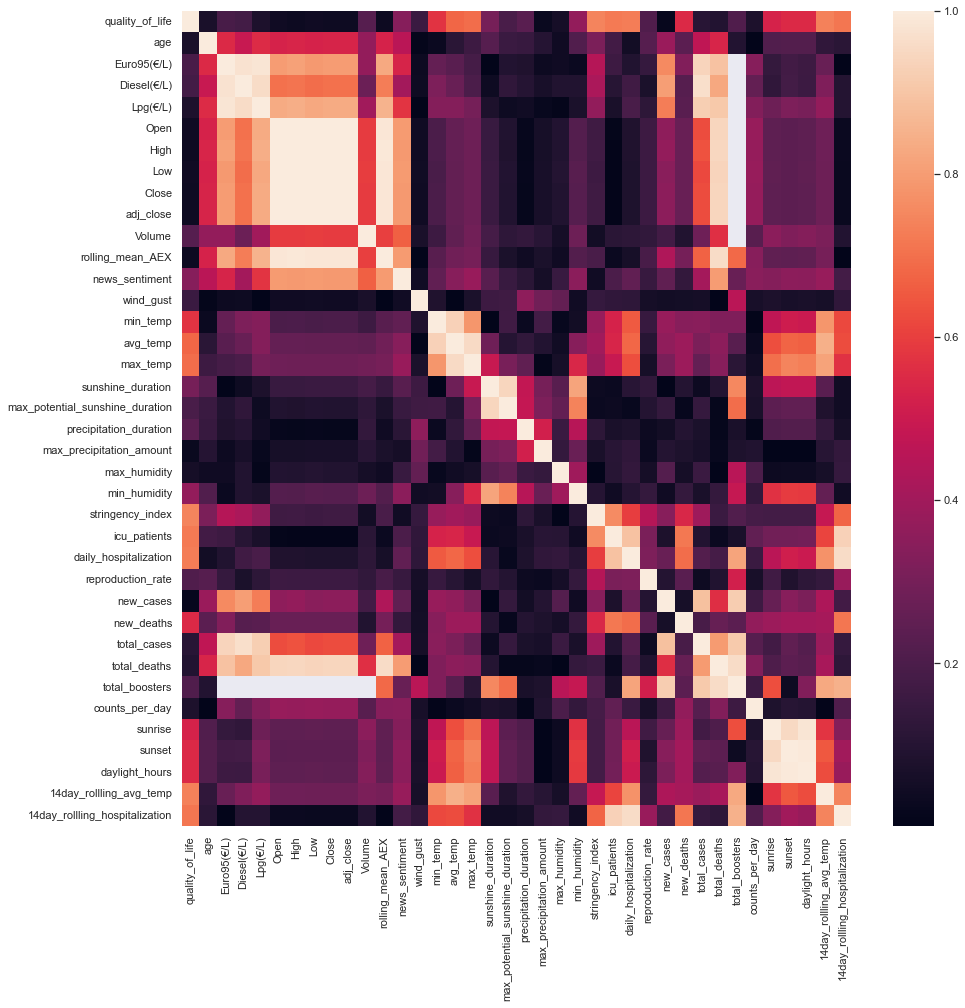

In [10]:
# Using Correlation
import seaborn as sns
cor=df.corr().abs()
sns.set(rc = {'figure.figsize':(15,15)})
sns.heatmap(cor)

In [11]:
# keep features except: ['Euro95(€/L)','Diesel(€/L)', 'Lpg(€/L)', 'Open', 'High', 'Low', 'Close', 'adj_close','Volume']
features=['quality_of_life','avg_temp', 'max_temp','stringency_index', 'icu_patients', 'daily_hospitalization','14day_rollling_avg_temp','14day_rollling_hospitalization']
print("Final counting the null data: " ,df[features].isna().sum().sum()) # check again if there is any nan value
df.head()

Final counting the null data:  0


,date,quality_of_life,age,Euro95(€/L),Diesel(€/L),Lpg(€/L),Open,High,Low,Close,...,new_deaths,total_cases,total_deaths,total_boosters,counts_per_day,sunrise,sunset,daylight_hours,14day_rollling_avg_temp,14day_rollling_hospitalization
1,2020-04-06,7.297588,54.378883,1.476,1.239,0.560,486.260010,491.679993,482.690002,489.820007,...,103.0,19617,1873,NaN,7340,6.900000,20.300000,13.400000,10.600000,2859.500000
2,2020-04-07,7.263230,55.309461,1.475,1.238,0.556,503.970001,508.559998,494.109985,499.850006,...,234.0,20589,2107,NaN,9914,6.866667,20.316667,13.450000,10.950000,2810.666667
3,2020-04-08,7.343911,55.432321,1.473,1.237,0.543,496.190002,500.709992,491.489990,500.709992,...,147.0,21802,2254,NaN,7543,6.833333,20.350000,13.516667,11.537500,2824.000000
4,2020-04-09,7.304743,55.732974,1.471,1.238,0.547,506.549988,511.929993,499.049988,508.040008,...,148.0,23140,2402,NaN,6857,6.783333,20.383333,13.600000,11.260000,2805.800000
5,2020-04-10,7.323265,55.054243,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,117.0,24463,2519,NaN,4996,6.750000,20.416667,13.666667,10.691667,2784.000000


In [12]:
#check the skew data
skew_columns = (df[features].skew())
skew_columns = skew_columns.loc[skew_columns > 0.75]
skew_columns

Series([], dtype: float64)

I used the pair plot to find the correlation between the remaining features to select the independent features to use in modeling.\
 Then I calculated the correlations and sort and you can see the first three ones are the best and they are independent of each other as well.

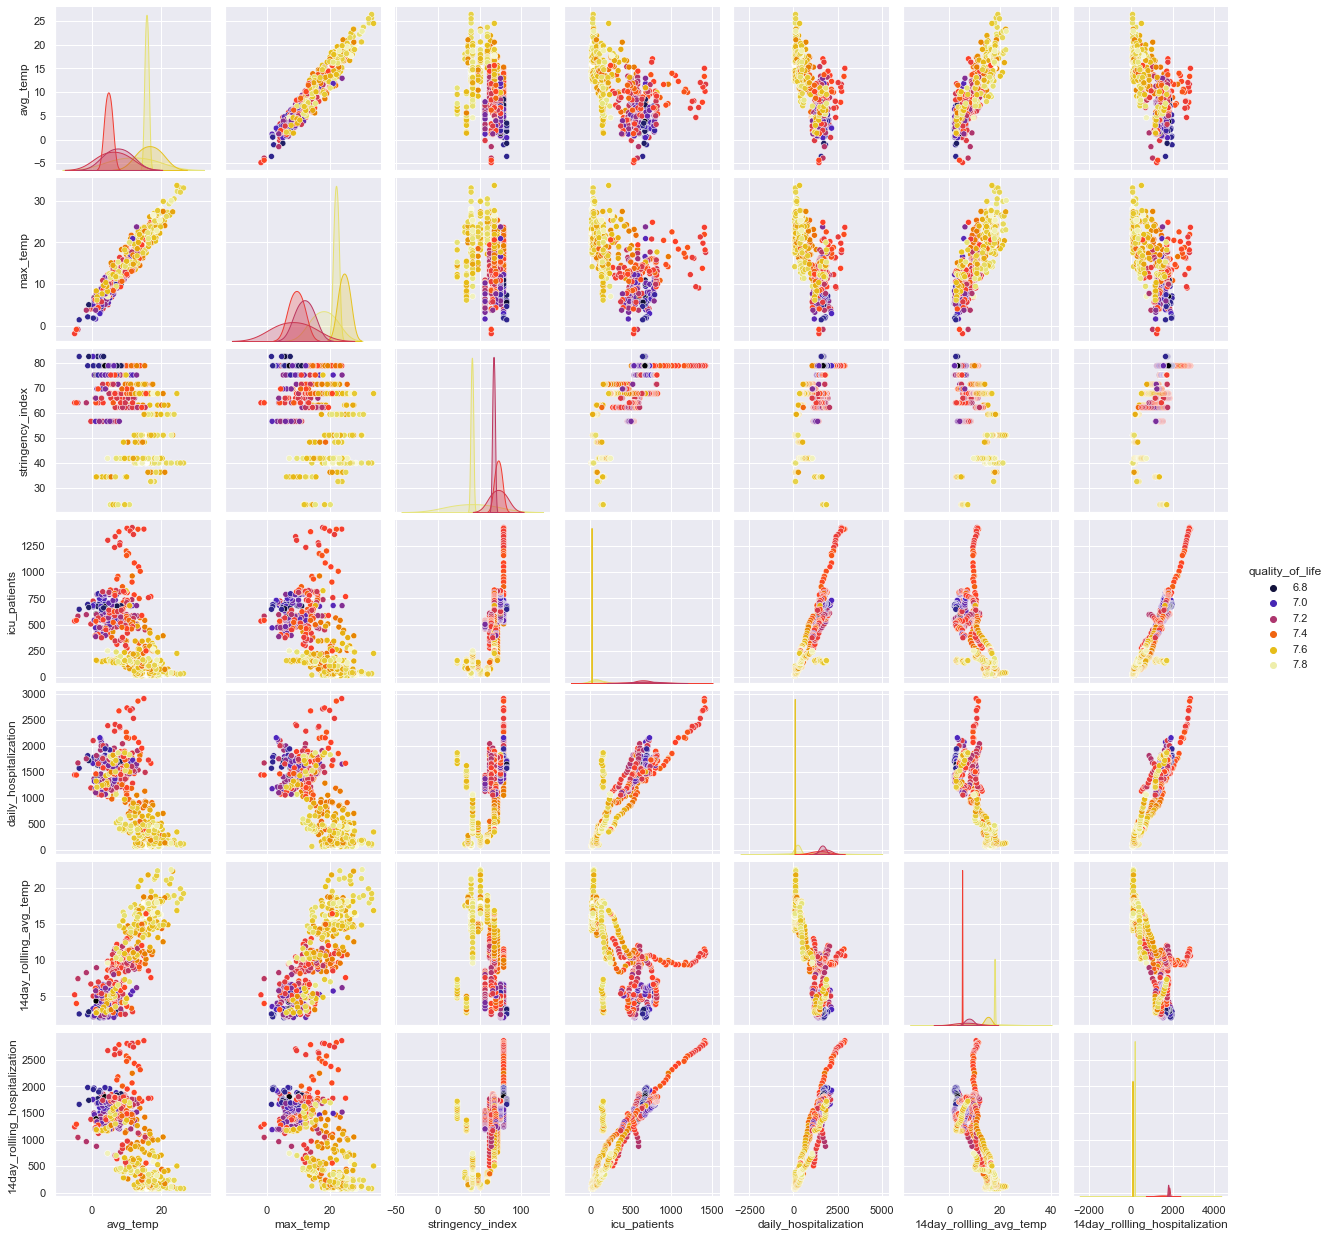

In [13]:
#make a pairplot
sns.pairplot(data=df[features], hue='quality_of_life', palette='CMRmap')

In [14]:
#Correlation of features with the output variable
cor_target = cor["quality_of_life"]
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.6].sort_values(ascending=False)
relevant_features


quality_of_life                   1.000000
stringency_index                  0.744872
14day_rollling_avg_temp           0.737582
daily_hospitalization             0.726907
icu_patients                      0.720177
14day_rollling_hospitalization    0.713093
max_temp                          0.694319
avg_temp                          0.676583
Name: quality_of_life, dtype: float64

### Finally, these 3 features are the best ones:
- 14day_rollling_avg_temp
- daily_hospitalization
- stringency_index\
So I made the X matrix as features and y as a target to use in different kinds of models.

In [15]:
# Create the X-matrix and the y-vector.
final_feature=['14day_rollling_avg_temp','daily_hospitalization','stringency_index']
y = df['quality_of_life'].values  #Target Variable
X = df[final_feature].values.reshape(-1, len(final_feature)) #reshape the Feature Matrix
print("size of features : ",X.shape)
print("size of target : ",y.shape)

size of features :  (463, 3)
size of target :  (463,)


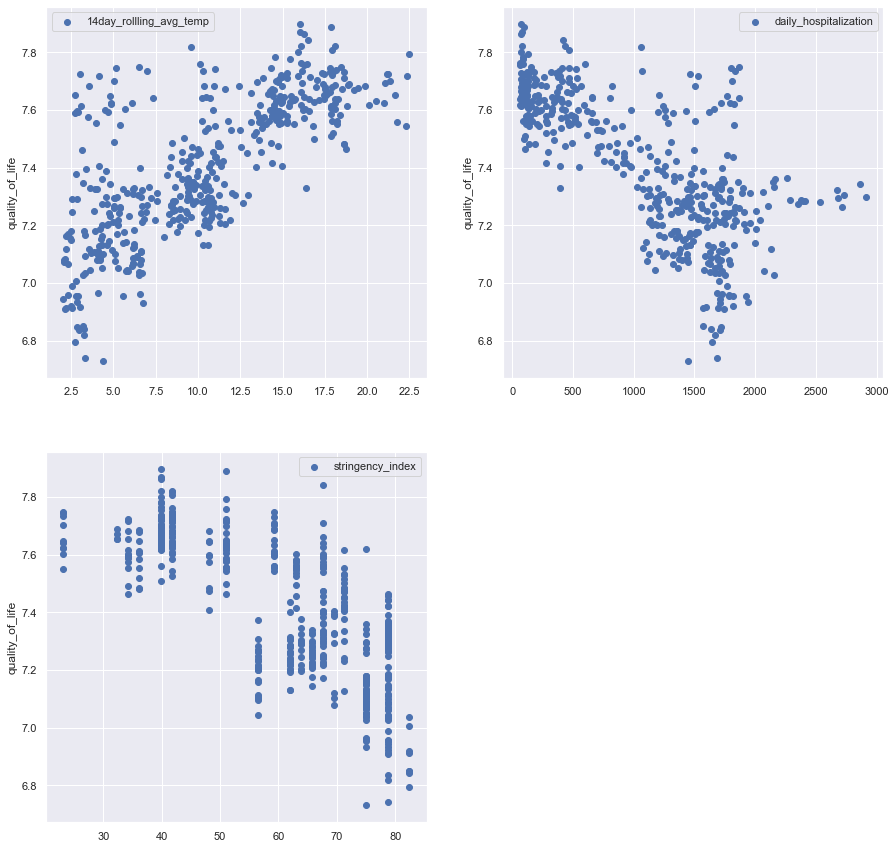

In [16]:
#scatter plots of important features and quality of life
plt.subplot(2,2,1)
plt.scatter(df['14day_rollling_avg_temp'],df['quality_of_life'],label="14day_rollling_avg_temp")
plt.ylabel("quality_of_life")
plt.legend()
plt.subplot(2,2,2)
plt.scatter(df['daily_hospitalization'],df['quality_of_life'] , label ="daily_hospitalization")
plt.ylabel("quality_of_life")
plt.legend()
plt.subplot(2,2,3)
plt.scatter(df['stringency_index'],df['quality_of_life'] , label="stringency_index")
plt.legend()
plt.ylabel("quality_of_life")
plt.show()


### Preprocessing the data

I checked the minimum and maximum standard deviation and as you can see there is a big difference between those so we need to normalize the data.

In [17]:
#check the variance to normalization
std=np.std(X,axis=0)
print("std_min : ",std.min(),"\n","std_max : ",std.max())

std_min :  5.253647457767895 
 std_max :  691.7618168985629


In [18]:
#function of normalization
def normalize(X):
     scalar = StandardScaler()
     X = scalar.fit_transform(X)
     return X
#normalize the features value
X = normalize(X)

Below is the Function of plotting the comparison of RMSE between the train and test dataset and I used it in all 3 models.

In [19]:
#Function of plotting the comparison of RMSE between train and test dataset
def plot_learning_curves(model, X_train, y_train, X_val, y_val):
    """
    input:
        model:pipeline object
        X_train, y_train: training data
        X_val, y_val: test data
    """
    train_errors, val_errors = [], []
    for m in range(30, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train_predict, y_train[:m]))
        val_errors.append(mean_squared_error(y_val_predict, y_val))
    plt.figure(figsize=(8,5))
    plt.plot(np.sqrt(train_errors), "r-.", linewidth=1, label="training data")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=1, label="validation data")
    plt.legend(loc="upper right", fontsize=10)   
    plt.xlabel("Training set size", fontsize=10) 
    plt.ylabel("RMSE", fontsize=10)     
    # compare accuracy train versus test to access overfit 
    print(f'test  acc: {model.score(X_val, y_val)}')
    print(f'train acc: {model.score(X_train, y_train)}')

At this level, I split the data to train and test by 0.8, and 0.2. Then I used 3 models: Linear regression, Polynomial Linear regression, and Random Forest, and then analyse the result of the models and compare them with each other to find the best model.

In [20]:
#Split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("train and test data are split:")
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

train and test data are split:
(370, 3) (370,)
(93, 3) (93,)


### Linear regression

Intercept:  7.404779257872782
Coefficients:  [ 0.09848538 -0.03387205 -0.1146089 ]
lin_reg_rmse :  0.11778688379496632
Linear Regression Accuracy:  0.7304848852103267
test  acc: 0.730450684915112
train acc: 0.7467571036878815


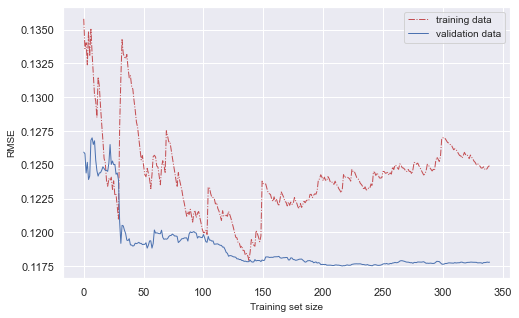

In [21]:
#---Linear Regression-----------------------------------------
line_reg=LinearRegression()
line_reg.fit(X_train,y_train)
print('Intercept: ', line_reg.intercept_)
print('Coefficients: ', line_reg.coef_)

#Predicting the y_value of linear regression
lin_reg_y_predicted = line_reg.predict(X_test)

#calculating the rmse 
lin_reg_rmse = np.sqrt(mean_squared_error(y_test, lin_reg_y_predicted))
print('lin_reg_rmse : ', lin_reg_rmse)

#Linear Regression Accuracy with test set
lin_reg_acc = r2_score(y_test, lin_reg_y_predicted)
print('Linear Regression Accuracy: ',lin_reg_acc)
plot_learning_curves(line_reg, X_train, y_train, X_test, y_test)

you can see the R2 of linear regression and also the accuracy of the train and test. There is an overfit after around 140 samples. This is acceptable for linear regression but still, needs more accuracy.

### Polynomial Linear Regression

Intercept:  -392799626554.5432
Coefficients:  [ 3.92799627e+11  1.22850497e-01 -1.70943518e-01  4.82765596e-02
 -6.74686126e-02 -1.73258174e-01  2.60834071e-02 -4.97958270e-02
 -5.02867856e-02  1.95476673e-01 -6.23772755e-03  1.48625719e-01
 -1.22974785e-01  1.15941371e-01 -1.51162658e-01  6.42529076e-02
  1.61164801e-01 -1.82519057e-01  4.11452374e-02 -4.18019097e-02
  4.90328063e-02  1.89387352e-01 -8.77696272e-02  2.14683447e-01
 -1.62915255e-01  4.04029875e-02 -9.12511737e-02  7.97450234e-02
  1.73141665e-01 -1.97743906e-03 -6.01307679e-02  8.55815293e-02
  3.98379579e-03  1.10936783e-02 -3.11568454e-02]
Polynomial_Regression_reg_rmse :  0.08717191628897501
Plynomial Regression Accuracy:  0.8523809357268349
test  acc: 0.8516835311276084
train acc: 0.868158554253071


(-5.0, 5.0)

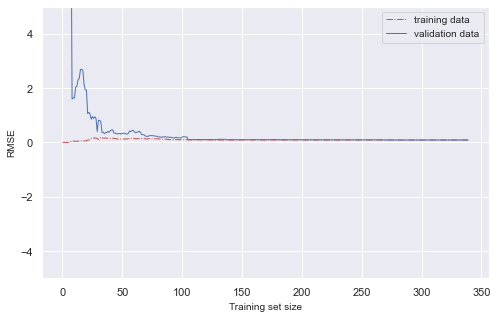

In [22]:
#---Polynomial Linear regression-----------------------------
poly_reg=PolynomialFeatures(degree=4)
X_poly_train,X_poly_test =poly_reg.fit_transform(X_train),poly_reg.fit_transform(X_test)

poly_reg_model = LinearRegression()
poly_reg_model.fit(X_poly_train, y_train)
print('Intercept: ', poly_reg_model.intercept_)
print('Coefficients: ', poly_reg_model.coef_)

#Predicting the y_value of polynomial linear regression
poly_reg_y_predicted = poly_reg_model.predict(X_poly_test)

#calculating the rmse 
poly_reg_rmse = np.sqrt(mean_squared_error(y_test, poly_reg_y_predicted))
print('Polynomial_Regression_reg_rmse : ', poly_reg_rmse)

#Plynomial Regression Accuracy with test set
poly_reg_acc = r2_score(y_test, poly_reg_y_predicted)
print('Plynomial Regression Accuracy: ',poly_reg_acc)
plot_learning_curves(poly_reg_model, X_poly_train, y_train, X_poly_test, y_test)
plt.ylim(-5,5)


As you can see there is a very good plot of polynomial linear regression with a good score in the train and test. So I think the polynomial is the good option but let's try to do another model as well and that is random forest because most of the time the random forest does the better performance in both. regression and classification

### Random Forest Regression

random_forest_reg_rmse :  0.08627635776643433
Random Forest Regression Accuracy:  0.8553984769769011
test  acc: 0.8548920328192477
train acc: 0.982454848668279


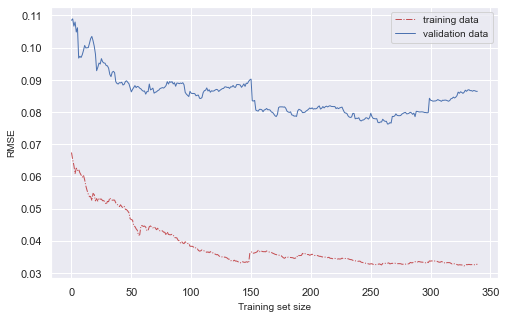

In [23]:
#---Random forest regression------------------------------------
rf_reg = RandomForestRegressor(n_estimators=200, random_state=0 )
rf_reg.fit(X_train,y_train)

#Predicting the y_value of random forest
rf_reg_y_predicted= rf_reg.predict(X_test)

#calculating the rmse 
rf_reg_rmse = np.sqrt(mean_squared_error(y_test, rf_reg_y_predicted))
print('random_forest_reg_rmse : ', rf_reg_rmse)

#Random Forest Regression Accuracy with test set
rf_reg_acc = r2_score(y_test, rf_reg_y_predicted)
print('Random Forest Regression Accuracy: ',rf_reg_acc)
plot_learning_curves(rf_reg, X_train, y_train, X_test, y_test)


with Random forest, I could get a better result score, especially on the train, and also the RMSE is under 0.1.\
Due to the accuracy of the three models, the results accuracy of Polynomial linear regression and random forest are very close to each other.
So, I tried repeating those two models with the different random states to check the accuracy and rmse

In [24]:
#function of Polynomial Linear regression
def poly_reg(degree,random_state):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
    poly_reg=PolynomialFeatures(degree=degree)
    X_poly_train,X_poly_test =poly_reg.fit_transform(X_train),poly_reg.fit_transform(X_test)
    poly_reg_model = LinearRegression()
    poly_reg_model.fit(X_poly_train, y_train)
    poly_reg_y_predicted = poly_reg_model.predict(X_poly_test)
    poly_reg_rmse = np.sqrt(mean_squared_error(y_test, poly_reg_y_predicted))
    print('Polynomial_Regression_reg_rmse : ', poly_reg_rmse)
    poly_reg_acc = r2_score(y_test, poly_reg_y_predicted)
    print('Plynomial Regression Accuracy: ',poly_reg_acc)


Bellow I checked the accuracy and rmse with different degrees of polynomial regression and as the result, the degree of 4 is the best one as I choose it before for polynomial regression.

In [25]:
#check the accuracy and rmse with different degree of polynomial regression
for i in [1,2,3,4,5,6]:
    poly_reg(degree=i,random_state=42)
# we can see that the best degree is 4

Polynomial_Regression_reg_rmse :  0.11778688379496631
Plynomial Regression Accuracy:  0.7304848852103267
Polynomial_Regression_reg_rmse :  0.0945071494292994
Plynomial Regression Accuracy:  0.8264923651626224
Polynomial_Regression_reg_rmse :  0.095160597538793
Plynomial Regression Accuracy:  0.824084712395211
Polynomial_Regression_reg_rmse :  0.08717191628897501
Plynomial Regression Accuracy:  0.8523809357268349
Polynomial_Regression_reg_rmse :  0.13270293957448967
Plynomial Regression Accuracy:  0.6579021471634353
Polynomial_Regression_reg_rmse :  0.13138031438420775
Plynomial Regression Accuracy:  0.6646874137340515


Bellow check the different accuracy and rsme with different randome satate of polynomial regression

In [26]:

for i in [10,20,30,40,50,60]:
    poly_reg(degree=4,random_state=i)

Polynomial_Regression_reg_rmse :  0.1469922665585638
Plynomial Regression Accuracy:  0.6385300556486996
Polynomial_Regression_reg_rmse :  0.09961994606637094
Plynomial Regression Accuracy:  0.8283657969875488
Polynomial_Regression_reg_rmse :  0.09582412328633107
Plynomial Regression Accuracy:  0.8546600873583988
Polynomial_Regression_reg_rmse :  0.10457774438256424
Plynomial Regression Accuracy:  0.7852677293716399
Polynomial_Regression_reg_rmse :  0.0966111639201108
Plynomial Regression Accuracy:  0.858285159534985
Polynomial_Regression_reg_rmse :  0.09834706755009877
Plynomial Regression Accuracy:  0.839941809857154


In [27]:
#function of random forest model
def random_forest(r_state):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=r_state)
    rf_reg = RandomForestRegressor(n_estimators=200, random_state=0 )
    rf_reg.fit(X_train,y_train)
    rf_reg_y_predicted= rf_reg.predict(X_test)
    rf_reg_rmse = np.sqrt(mean_squared_error(y_test, rf_reg_y_predicted))
    print('random_forest_reg_rmse : ', rf_reg_rmse)
    rf_reg_acc = r2_score(y_test, rf_reg_y_predicted)
    print('Random Forest Regression Accuracy: ',rf_reg_acc)
   

Bellow I checked different accuracy with repeating the random forest model with various random states

In [28]:
#check different accuracy with repeating the random forest model
for i in [10,20,30,40,50,60]:
    random_forest(r_state=i)

random_forest_reg_rmse :  0.07553490889230297
Random Forest Regression Accuracy:  0.9045494053217116
random_forest_reg_rmse :  0.09522658321058004
Random Forest Regression Accuracy:  0.8431705436902288
random_forest_reg_rmse :  0.09391229133533659
Random Forest Regression Accuracy:  0.8604017224931368
random_forest_reg_rmse :  0.09000787009026613
Random Forest Regression Accuracy:  0.8409331263474255
random_forest_reg_rmse :  0.08952374673286492
Random Forest Regression Accuracy:  0.8783149560011871
random_forest_reg_rmse :  0.09128613480334584
Random Forest Regression Accuracy:  0.8620998592438405


As a result, although the polynomial linear regression has a better accuracy between train and test(as you can see in the curve plot), the random forest model has the better accuracy during repetition and it is not under 84%(sometimes 90%), Also we can see during the repetition the RMSE is not more than 1%, so I think the random forest is more acceptable for modeling rather than others. and it was predictable because the result of random forest is the average of 200 trees, so most of the time the result of that is more accurate than other regression methods.

In [29]:
#compare R2 of three models
print('R2 of Linear regression : '+ '{}'.format(lin_reg_acc))
print('R2 of Plynomial regression(degree=4) : '+ '{}'.format(poly_reg_acc))
print('R2 of Random forest : '+ '{}'.format(rf_reg_acc))

R2 of Linear regression : 0.7304848852103267
R2 of Plynomial regression(degree=4) : 0.8523809357268349
R2 of Random forest : 0.8553984769769011


Finally, I used the random forest to predict the whole dataset to see the actual quality of life and predicted quality of life by the random forest model.

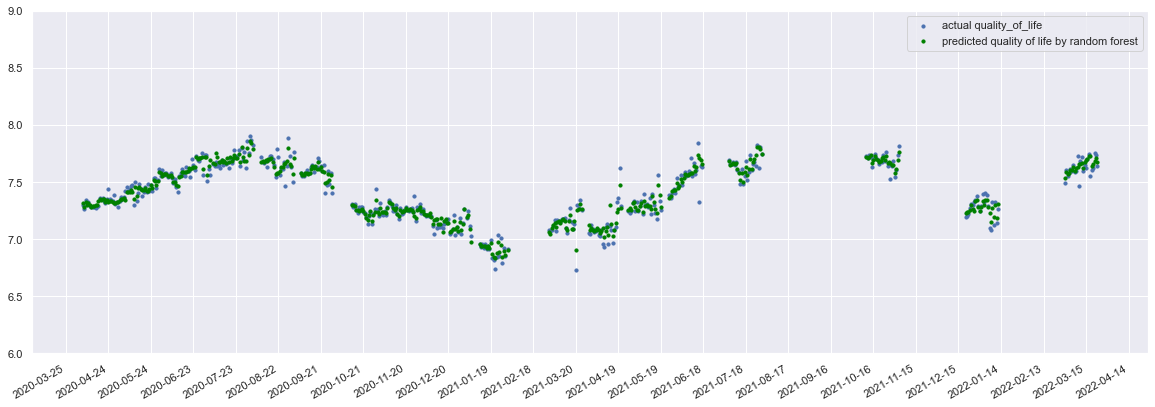

In [30]:
#predict the whole data frame by the random forest model.
df['y_pred_rf']=rf_reg.predict(X)

plt.figure(figsize=(20,7))
plt.scatter(df['date'],df['quality_of_life'],label='actual quality_of_life',s=10)
plt.scatter(df['date'],df['y_pred_rf'],label='predicted quality of life by random forest',s=10,color='green')
plt.ylim(6,9)
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=30))
plt.gcf().autofmt_xdate()
plt.legend()
plt.show()